In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
def calculate_distance(city1, city2):
    return np.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

In [4]:
def calculate_tour_distance(tour, cities):
    distance = 0.0
    for i in range(len(tour)):
        j = (i + 1) % len(tour)
        distance += calculate_distance(cities[tour[i]], cities[tour[j]])
    return distance

In [5]:
def initialize_population(pop_size, num_cities):
    population = []
    for _ in range(pop_size):
        tour = list(range(num_cities))
        random.shuffle(tour)
        population.append(tour)
    return population

In [6]:
def order_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))

    offspring = [-1] * size

    offspring[start : end + 1] = parent1[start : end + 1]

    pointer = (end + 1) % size
    for i in range(size):
        parent2_idx = (end + 1 + i) % size
        if parent2[parent2_idx] not in offspring:
            offspring[pointer] = parent2[parent2_idx]
            pointer = (pointer + 1) % size

    return offspring

In [7]:
def swap_mutation(tour, mutation_rate=0.3):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(tour)), 2)
        tour[i], tour[j] = tour[j], tour[i]
    return tour

In [8]:
def tournament_selection(population, fitnesses, tournament_size=3):
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    selected.sort(key=lambda x: x[1])
    return selected[0][0]

In [9]:
def two_opt(tour, cities):
    def _two_opt_swap(tour, i, j):
        new_tour = tour[:i] + tour[i:j + 1][::-1] + tour[j + 1:]
        return new_tour

    best = tour.copy()
    best_distance = calculate_tour_distance(best, cities)
    n = len(best)

    improved = True
    while improved:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                new_tour = _two_opt_swap(best, i, j)
                new_distance = calculate_tour_distance(new_tour, cities)
                if new_distance < best_distance:
                    best = new_tour
                    best_distance = new_distance
                    improved = True
                    break
            if improved:
                break

    return best

In [10]:
def three_opt(tour, cities):
    best = tour.copy()
    best_distance = calculate_tour_distance(best, cities)
    n = len(best)

    improved = True
    while improved:
        improved = False
        for i in range(1, n - 4):
            for j in range(i + 1, n - 2):
                for k in range(j + 1, n):
                    a = best[:i]
                    b = best[i:j]
                    c = best[j:k]
                    d = best[k:]

                    candidates = [
                        a + b[::-1] + c + d,
                        a + b + c[::-1] + d,
                        a + c + b + d,
                        a + c[::-1] + b + d,
                        a + c + b[::-1] + d,
                        a + b[::-1] + c[::-1] + d,
                        a + c[::-1] + b[::-1] + d,
                    ]

                    for cand in candidates:
                        dist = calculate_tour_distance(cand, cities)
                        if dist < best_distance - 1e-9:
                            best = cand
                            best_distance = dist
                            improved = True
                            break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break

    return best

In [11]:
def genetic_algorithm(
    cities,
    target,
    pop_size=100,
    generations=500,
    mutation_rate=0.3,
    tournament_size=3,
    use_2opt=False,
    two_opt_rate=0.3,
    final_3opt=False,
):
    num_cities = len(cities)

    population = initialize_population(pop_size, num_cities)

    best_tour = None
    best_distance = float("inf")
    best_history = []

    for gen in range(generations):
        fitnesses = [calculate_tour_distance(tour, cities) for tour in population]

        gen_best_idx = np.argmin(fitnesses)
        if fitnesses[gen_best_idx] < best_distance:
            best_distance = fitnesses[gen_best_idx]
            best_tour = population[gen_best_idx].copy()
            best_history.append(best_distance)

            if best_distance <= target:
                print(f"Target distance reached in generation {gen + 1}")
                break

        new_population = []

        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)

            offspring = order_crossover(parent1, parent2)

            offspring = swap_mutation(offspring, mutation_rate)

            if use_2opt and random.random() < two_opt_rate:
                offspring = two_opt(offspring, cities)

            new_population.append(offspring)

        population = new_population

        if (gen + 1) % 5 == 0:
            print(f"Generation {gen + 1}: Best Distance = {best_distance:.2f}")

    if final_3opt:
        print("Applying final 3-opt to best tour...")
        best_tour = three_opt(best_tour, cities)
        best_distance = calculate_tour_distance(best_tour, cities)

    return best_tour, best_distance, best_history

In [12]:
def plot_solution(cities, best_tour, best_distance):
    plt.figure(figsize=(10, 6))

    x_coords = [cities[i][0] for i in best_tour] + [cities[best_tour[0]][0]]
    y_coords = [cities[i][1] for i in best_tour] + [cities[best_tour[0]][1]]

    plt.plot(x_coords, y_coords, "b-", alpha=0.6, linewidth=1)
    plt.scatter(
        [c[0] for c in cities], [c[1] for c in cities], c="red", s=100, zorder=5
    )

    for i, (x, y) in enumerate(cities):
        plt.annotate(
            f"{i}", (x, y), xytext=(5, 5), textcoords="offset points", fontsize=10
        )

    plt.title(f"Best TSP Solution (Distance: {best_distance:.2f})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, alpha=0.3)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

In [13]:
def read_cities_from_file(filename):
    cities = []
    with open(filename, "r") as file:
        for line in file:
            x, y = map(lambda s: int(float(s)), line.strip().split())
            cities.append((x, y))
    return cities

In [14]:
TARGET = 7544.37
POPULATION_SIZE = 100
GENERATIONS = 500
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3

In [15]:
cities = read_cities_from_file("berlin52.tsp")

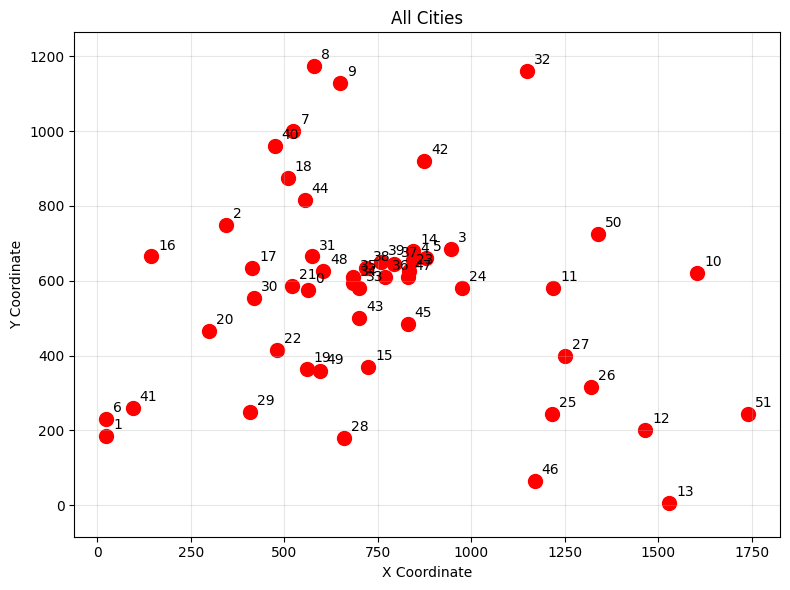

In [16]:
plt.figure(figsize=(8, 6))

plt.scatter([c[0] for c in cities], [c[1] for c in cities], c="red", s=100)
for i, (x, y) in enumerate(cities):
    plt.annotate(f"{i}", (x, y), xytext=(5, 5), textcoords="offset points", fontsize=10)
plt.title("All Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True, alpha=0.3)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [17]:
print(f"Solving TSP with {len(cities)} cities...")
print(f"Population size: {POPULATION_SIZE}")
print(f"Generations: {GENERATIONS}")
print("="*40)

Solving TSP with 52 cities...
Population size: 100
Generations: 500


Generation 5: Best Distance = 22437.30
Generation 10: Best Distance = 21389.39
Generation 15: Best Distance = 18761.56
Generation 20: Best Distance = 18129.34
Generation 25: Best Distance = 18093.67
Generation 30: Best Distance = 17827.79
Generation 35: Best Distance = 16959.38
Generation 40: Best Distance = 16332.14
Generation 45: Best Distance = 16332.14
Generation 50: Best Distance = 15964.66
Generation 55: Best Distance = 15209.98
Generation 60: Best Distance = 14839.18
Generation 65: Best Distance = 14584.53
Generation 70: Best Distance = 14584.53
Generation 75: Best Distance = 14422.69
Generation 80: Best Distance = 14422.69
Generation 85: Best Distance = 14422.69
Generation 90: Best Distance = 14291.90
Generation 95: Best Distance = 14291.90
Generation 100: Best Distance = 14291.90
Generation 105: Best Distance = 14150.44
Generation 110: Best Distance = 13924.48
Generation 115: Best Distance = 13593.95
Generation 120: Best Distance = 13593.95
Generation 125: Best Distance = 1359

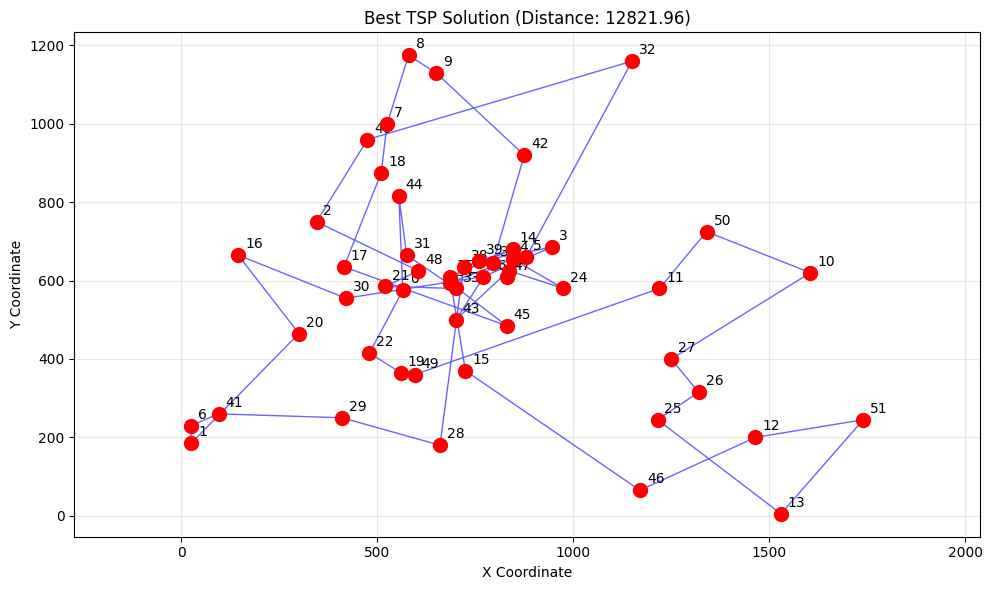

In [18]:
best_tour, best_distance, history = genetic_algorithm(
    cities, TARGET, POPULATION_SIZE, GENERATIONS, MUTATION_RATE, TOURNAMENT_SIZE
)

print("\n" + "=" * 40)
print(f"Final Best Tour: {best_tour}")
print(f"Final Best Distance: {best_distance:.2f}")

plot_solution(cities, best_tour, best_distance)

Generation 5: Best Distance = 8267.32
Generation 10: Best Distance = 8210.85
Generation 15: Best Distance = 7759.37
Generation 20: Best Distance = 7759.37
Generation 25: Best Distance = 7759.37
Generation 30: Best Distance = 7759.37
Generation 35: Best Distance = 7759.37
Generation 40: Best Distance = 7759.37
Generation 45: Best Distance = 7718.45
Generation 50: Best Distance = 7718.45
Generation 55: Best Distance = 7718.45
Generation 60: Best Distance = 7716.86
Generation 65: Best Distance = 7716.86
Generation 70: Best Distance = 7619.15
Generation 75: Best Distance = 7619.15
Generation 80: Best Distance = 7619.15
Generation 85: Best Distance = 7619.15
Generation 90: Best Distance = 7619.15
Generation 95: Best Distance = 7619.15
Target distance reached in generation 100

Final Best Tour: [45, 43, 33, 34, 35, 38, 39, 36, 37, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 12, 13, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48, 0, 21, 30, 17, 2, 16, 20, 41, 6, 1, 29, 22, 19, 49, 28, 15]
F

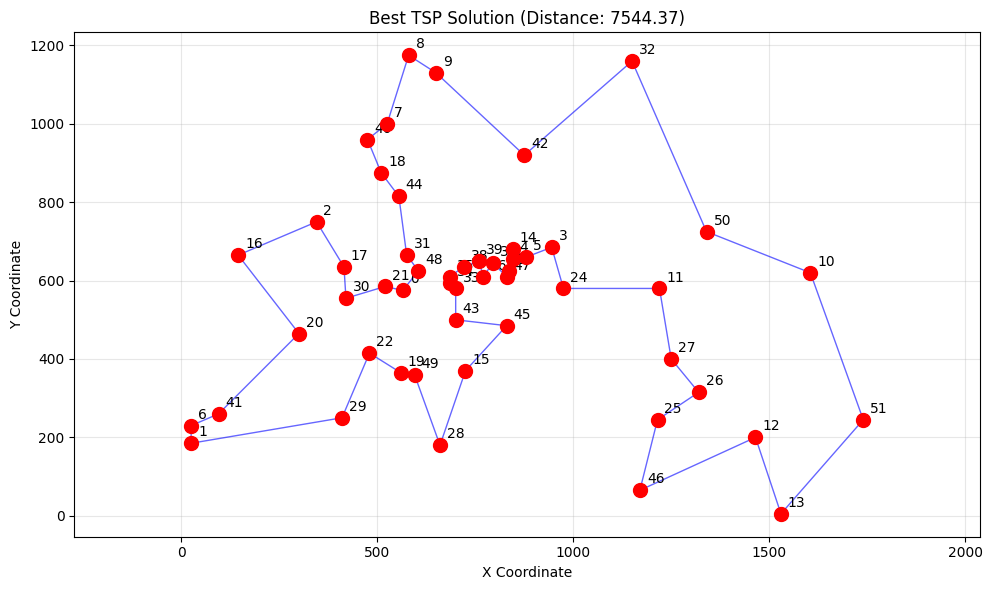

In [19]:
best_tour, best_distance, history = genetic_algorithm(
    cities, TARGET, POPULATION_SIZE, GENERATIONS, MUTATION_RATE, TOURNAMENT_SIZE, use_2opt=True, two_opt_rate=0.01
)

print("\n" + "=" * 40)
print(f"Final Best Tour: {best_tour}")
print(f"Final Best Distance: {best_distance:.2f}")

plot_solution(cities, best_tour, best_distance)

Generation 5: Best Distance = 24387.66
Generation 10: Best Distance = 22403.64
Generation 15: Best Distance = 20479.33
Generation 20: Best Distance = 18460.43
Generation 25: Best Distance = 17407.89
Generation 30: Best Distance = 16803.45
Generation 35: Best Distance = 14459.77
Generation 40: Best Distance = 14029.22
Generation 45: Best Distance = 14029.22
Generation 50: Best Distance = 13347.90
Generation 55: Best Distance = 13347.90
Generation 60: Best Distance = 13347.90
Generation 65: Best Distance = 13347.90
Generation 70: Best Distance = 13347.90
Generation 75: Best Distance = 13347.90
Generation 80: Best Distance = 13347.90
Generation 85: Best Distance = 13347.90
Generation 90: Best Distance = 13347.90
Generation 95: Best Distance = 13347.90
Generation 100: Best Distance = 13347.90
Generation 105: Best Distance = 13347.90
Generation 110: Best Distance = 13347.90
Generation 115: Best Distance = 13347.90
Generation 120: Best Distance = 13347.90
Generation 125: Best Distance = 1334

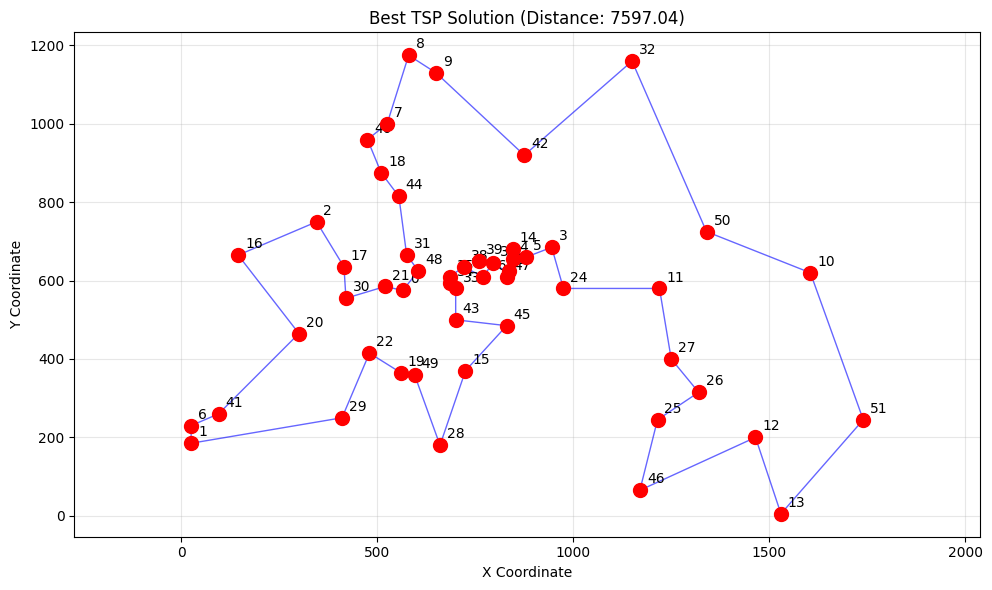

In [20]:
best_tour, best_distance, history = genetic_algorithm(
    cities, TARGET, POPULATION_SIZE, GENERATIONS, MUTATION_RATE, TOURNAMENT_SIZE, final_3opt=True
)

print("\n" + "=" * 40)
print(f"Final Best Tour: {best_tour}")
print(f"Final Best Distance: {best_distance:.2f}")

plot_solution(cities, best_tour, best_distance)